<a href="https://colab.research.google.com/github/ling-zhang-linnet/two-stage-dcopf-neural-solver/blob/main/rld_118bus_(step1)baseline_solvers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# in case gpu is used
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
import os, time
import cvxpy as cp
import random
from numpy import savetxt
import argparse
import json
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams['text.usetex'] = True

from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import torch.distributions.multivariate_normal as tdm

root_path = './gdrive/MyDrive/Inbox/rld_neural_policy/'

# helper functions, can be folded

## utils.py

In [ ]:
def create_dir(PATH):
    isExist = os.path.exists(PATH)

    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(PATH)
        print("The new directory is created!")


# Evaluate using vector distance
def measure_relative_distance(v1, v2):
    '''
        Note that v1 is the benchmark.
        Norm is calculated along dimension/axis 1
        and average is calculated along dimension/axis 0
        Also return the distance vetor.
    '''
    if len(v1.shape)==1 and len(v2.shape)==1:
        distance = np.abs(v1-v2)/np.abs(v1)

    if len(v1.shape)==2 and len(v2.shape)==2:
        distance = np.linalg.norm(v1-v2, axis=1)/np.linalg.norm(v1, axis=1)

    return distance, np.mean(distance)

## models.py

In [ ]:
class ActionNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(ActionNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, H)
        self.linear5 = torch.nn.Linear(H, D_out)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.25)


    def forward(self, input):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """

        x = F.relu(self.linear1(input))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        x = F.relu(self.linear3(x))
        x = self.dropout(x)
        x = F.relu(self.linear4(x))
        x = self.dropout(x)
        y_pred = F.relu(self.linear5(x))


        return y_pred


class RewardNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(RewardNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, H)
        self.linear5 = torch.nn.Linear(H, D_out)

    def forward(self, input):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
       
        x = F.relu(self.linear1(input))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        y_pred = torch.tanh(self.linear5(x))


        return y_pred


class TrainDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    # must override two of the subclass functions:
    def __len__(self):
        # return len(self.samples)
        return self.samples.shape[0]

    def __getitem__(self, idx):
        # return self.samples[idx]
        return self.samples[idx,:]


def init_weights(m):
    if isinstance(m, nn.Linear):

        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0.001)
        # m.bias.data.uniform_(0, y)

        # torch.nn.init.xavier_uniform_(m.weight)
        # m.bias.data.fill_(0.01)

        # How to call this function:
        # net.apply(init_weights)


## gauge.py

In [ ]:
def gauge_function(V, G, H):
    """
    The gauge function of the vector z w.r.t. the set P
    is given by the following code.

    V can be batched, for example, r-dimensional and batch size of K, then shape(V) = (r, K)
    Note that the second dimension is the batch.

    P is defined by {v: G@v <= Hj} = {v: g_i^T@v <= Hj_i, i = 1, ..., q}
    shape(G) = (q, r), shape(Hj) = (q, 1), shape(H) = (q, K)
    P must contain the origin in its interior.
    
    """
    # return torch.max(G@V/H,dim = 0).values # shape(output) = (1, K)

    # torch.div() for element-wide division
    return torch.max(torch.div(G@V, H),dim = 0).values # shape(output) = (1, K)

def gauge_map(Z, G, H):
    """
    For any Z \belongsto B_infinity, the gauge map from B_infinity to the set P
    defined by {v: G@v <= h} is given by the following code.
    
    Z can be batched, for example, r-dimensional and batch size of K, then shape(V) = (r, K)
    Note that the second dimension is the batch.

    P is defined by {v: G@v <= Hj} = {v: g_i^T@v <= Hj_i, i = 1, ..., q}
    shape(G) = (q, r), shape(Hj) = (q, 1), shape(H) = (q, K)
    P must contain the origin in its interior.
    """

    gamma_dest = gauge_function(Z, G, H)# shape = (1, K)
    # print('gamma_dest:', gamma_dest)
    gamma_start = torch.linalg.norm(Z, ord = np.inf, dim=0) # shape(1, K)

    scaling_mat = torch.diag(gamma_start/gamma_dest) # shape = (K, K)

    return Z@scaling_mat # shape = (r, K), this is the new point in P

## paths.py




In [ ]:
def get_paths():
    params_path = root_path+'118bus/params/'
    # data_path = root_path+'118bus/step1/'
    data_path = root_path+'118bus/data/'
    model_path = root_path+'118bus/step2/'
    saved_path = root_path+'118bus/step3/'


    isExist = os.path.exists(data_path)
    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(data_path)

    isExist = os.path.exists(model_path)
    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(model_path)
    
    isExist = os.path.exists(saved_path)
    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(saved_path)

    return params_path, data_path, saved_path, model_path

In [ ]:
def load_saved_models(model_path):

    action_net = ActionNet(N, 256, N)
    action_net.load_state_dict(torch.load(model_path+'trained_action_net.pt'))

    reward_net = RewardNet(N, 256, N-1)
    reward_net.load_state_dict(torch.load(model_path+'trained_reward_net.pt'))

    return action_net, reward_net


def load_pretrain_models(model_path):

    action_net = ActionNet(N, 256, N)
    action_net.load_state_dict(torch.load(model_path+'trained_action_net_sl.pt'))

    reward_net = RewardNet(N, 256, N-1)
    reward_net.load_state_dict(torch.load(model_path+'trained_reward_net_sl.pt'))

    return action_net, reward_net


def load_cost_coeff(params_path):    
    quad_cost_coeff = np.load(params_path+'quad_cost_coeff.npy')
    linear_cost_coeff = np.load(params_path+'linear_cost_coeff.npy')
    da_cost_coeff = np.load(params_path+'da_cost_coeff.npy')

    return quad_cost_coeff, linear_cost_coeff, da_cost_coeff

## dataloader.py

In [ ]:
def generate_inputs(Ntr, Ntst, Ntr2, scaling, nominal_PD_data, data_path):


    forecast = nominal_PD_data.flatten()

    std_vec = forecast*scaling
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    train_dataset = np.random.multivariate_normal(forecast, np.diag(std_vec), Ntr)
    train_dataset = np.clip(train_dataset, a_min=0., a_max=None)

    test_dataset = np.random.multivariate_normal(forecast, np.diag(std_vec), Ntst)
    test_dataset = np.clip(train_dataset, a_min=0., a_max=None)

    # Generate dataset for pretrain
    random_rows = np.random.choice(Ntr, Ntr2)
    pretrain_dataset = train_dataset[random_rows,:]
    print('pretrain_dataset:', pretrain_dataset.shape)

    np.save(data_path+'train_set.npy', train_dataset)
    np.save(data_path+'test_set.npy', test_dataset)
    np.save(data_path+'pretrain_set.npy', pretrain_dataset)

    return train_dataset, test_dataset, pretrain_dataset

In [ ]:
def for_sinlge_instance(forecast, x):

    theta = cp.Variable((N-1,1))
    y = cp.Variable((N, 1))

    constraints_list = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    rt_scenario = np.random.multivariate_normal(PD, np.diag(std_vec), 1)
    # generated scenario are arranged in rows, must be transposed
    rt_scenario = np.clip(rt_scenario, a_min=0., a_max=None).T
    assert rt_scenario.shape[0] == N
    
    net_d_omega = rt_scenario - x

    constraints_list.append( y == Yrr@theta + net_d_omega )
        
    constraints_list.append( Arr@theta <= Fmax*np.ones((num_lines, 1)))
    constraints_list.append( Arr@theta >= -Fmax*np.ones((num_lines, 1)))

    constraints_list.append( theta<=np.pi)
    constraints_list.append( theta>=-np.pi)

    Q_pred = cp.pos(y.T)@linear_cost_Coeff

    prob = cp.Problem(cp.Minimize( Q_pred ), constraints_list)

    prob.solve(verbose = False, solver = cp.ECOS) ## Works!   

    return prob.value, y.value, theta.value, net_d_omega

In [ ]:
def solve_stochastic_dcopf(forecasts, x_vals):
    '''
    Given a single instance and the initial dispatch x, and evaluate the quality
    of x.
    This function can be applied to the decision obtained from any policy.
    '''
    num_points = forecasts.shape[0]

    Q_vals = []
    y_vals = []
    theta_vals = []
    net_d_vals = []
    for i in range(num_points):
        forecast = forecasts[i,:].reshape(-1,1)
        x = x_vals[i,:].reshape(-1,1)

        Q_omega, y_omega, theta_omega, net_d_omega = for_sinlge_instance(forecast, x)

        Q_vals.append(Q_omega)
        y_vals.append(y_omega.flatten())
        theta_vals.append(theta_omega.flatten())
        net_d_vals.append(net_d_omega.flatten())

    Q_vals = np.array(Q_vals).reshape(-1,1)
    y_vals = np.array(y_vals)
    theta_vals = np.array(theta_vals)
    net_d_vals = np.array(net_d_vals)

    return Q_vals, y_vals, theta_vals, net_d_vals


## system.py

In [ ]:
def identify_unique_lines(connections):
    all_lines = {}
    count = 0
    for line in connections:
        all_lines[count] = line
        count+=1

    # This code snippet only finds out the repeated lines with exactly the same order of nodes,
    # but not deal with that [i,j] and [j,i] are also repeated lines
    # By checking connections, there is no repeated lines like [i,j] and [j,i]
    unique_lines = {}
    for k, val in all_lines.items():
        if val not in unique_lines.values():
            unique_lines[k]=val
    print('unique_lines length:', len(unique_lines))

    repeated_lines = [[42, 49],[49, 54],[56, 59],[49, 66],[77, 80],[89, 90],[89, 92]]
    # For example, [42, 49] appears twice
    set1 = {}
    set2 = {}
    for k, val in all_lines.items():
        if val in repeated_lines and k in unique_lines:
            set1[val[0], val[1]] = k # Record the repeated lines when they first appear
        if val in repeated_lines and k not in unique_lines:
            set2[val[0], val[1]] = k # Record the repeated lines when they appear more than once

    # print('set1:', len(set1))
    # print('set2:', len(set2))

    return unique_lines, set1, set2


def get_Y(N, B):
    # N = num_buses
    Y = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i==j : 
                Y[i,j] = sum(B[i,:])
            else: 
                Y[i,j] = -B[i,j]

    return Y[:,1:]


def get_A(N, L, B, connections):
    # N = num_buses
    # L = num_lines 
    A = np.zeros((L, N))

    for i, line in enumerate(connections):
        row = line[0]-1
        col = line[1]-1
        A[i, row] = B[row,col]
        A[i, col] = -B[row,col]

    return A[:,1:]


# Import 118bus
def import_118bus(params_path):
    bus_data_fname = '118bus_BusData.csv'
    gen_data_fname = '118bus_GenData.csv'

    branch_data_fname = '118bus_BranchData.csv'
    cost_data_fname = '118bus_CostData.csv'

    bus_data_df = pd.read_csv(params_path+bus_data_fname,header=None)
    gen_data_df = pd.read_csv(params_path+gen_data_fname,header=None)
    branch_data_df = pd.read_csv(params_path+branch_data_fname,header=None)
    cost_data_df = pd.read_csv(params_path+cost_data_fname,header=None)


    num_buses = bus_data_df.shape[0]
    num_lines = branch_data_df.shape[0]
    num_gens = gen_data_df.shape[0]


    bus_data = bus_data_df.to_numpy()
    gen_data = gen_data_df.to_numpy()
    branch_data = branch_data_df.to_numpy()
    cost_data = cost_data_df.to_numpy()

    x = branch_data[:,3]
    print('max of x:', max(x))
    print('min of x:', min(x))


    b = 1/x
    Z0 = 10
    b = b/Z0
    print('max of b:', max(b))
    print('min of b:', min(b))

    connections = []
    branches = branch_data[:,:2]
    for i in range(branches.shape[0]):
            connections.append([int(branches[i,0]),int(branches[i,1])])
    print('len of connections:', len(connections))

    unique_lines, set1, set2 = identify_unique_lines(connections)

    B = np.zeros((num_buses, num_buses))
    for k, line in unique_lines.items():
        row = line[0]-1
        col = line[1]-1
        B[row, col] = b[k]
        B[col, row] = b[k]

    PD = bus_data[:,2]/20
    print('Total PD:', sum(PD))

    return num_buses, num_lines, B, connections, PD

### import B, F and cost

In [ ]:
params_path, data_path, saved_path, model_path = get_paths()

num_buses, num_lines, B, connections, PD_data = import_118bus(params_path)

N = num_buses
L = num_lines 

Yrr = get_Y(num_buses, B)
Arr = get_A(num_buses, num_lines, B, connections)

# Define feasibility set for gauge mapping
G = np.block([
              [Arr],
              [-Arr],
              [np.eye(N-1)],
              [-np.eye(N-1)]
])
print('G shape:', G.shape)

# Load cost coefficients
quad_cost_coeff, linear_cost_coeff, da_cost_coeff = load_cost_coeff(params_path) 

quad_cost_Coeff = np.diag(quad_cost_coeff)
linear_cost_Coeff = linear_cost_coeff.reshape(-1, 1)
da_cost_Coeff = da_cost_coeff.reshape(-1,1)

print('quad_cost_Coeff shape:', quad_cost_Coeff.shape)
print('linear_cost_Coeff shape:', linear_cost_Coeff.shape)
print('da_cost_Coeff shape:', da_cost_Coeff.shape)

max of x: 0.411
min of x: 0.004
max of b: 25.0
min of b: 0.24330900243309003
len of connections: 186
unique_lines length: 179
Total PD: 212.10000000000005
G shape: (606, 117)
quad_cost_Coeff shape: (118, 118)
linear_cost_Coeff shape: (118, 1)
da_cost_Coeff shape: (118, 1)


### set Fmax and std

In [ ]:
Fmax = 1.5
input_std = 0.1
sce_std = 0.05

## benchmarks.py

### gap

In [ ]:
def solve_GAP(forecast, num_sce):
    '''
    Given a single instance of forecast, solve the SAA version
    of the true problem, but with theta approximated by affine policy.
    This is called ap policy in our work.
    '''

    M = num_sce

    c = da_cost_Coeff
    q = linear_cost_Coeff
    B = -Yrr
    F = Arr
    rho_lb = 10.
    rho_ub = 10.

    Brr = -Yrr[1:,:]
    Brr_inv = np.linalg.inv(Brr)
    I = np.eye(N)
    R = I[1:,:]
    ones = np.ones((N,1))
    
    alpha = cp.Variable((N, 1))
    beta = cp.Variable((N,1))

    x = cp.Variable((N, 1))

    constraints_list = []

    Q_vals = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):
        # for each scenario of noise
        noise_sce =  scenarios[:, m:m+1] - forecast
        net_d = scenarios[:, m:m+1] - x

        y_pred = (ones.T@noise_sce)*alpha + beta
        theta_pred = Brr_inv@R@(net_d-y_pred)

        p_f_lb = rho_lb*cp.norm( cp.pos(-Fmax*np.ones((num_lines, 1)) - F@theta_pred) )
        p_f_ub = rho_ub*cp.norm( cp.pos(F@theta_pred -Fmax*np.ones((num_lines, 1))) )

        p_v_lb  = rho_lb*cp.norm( cp.pos(-np.pi*np.ones((N-1, 1)) - theta_pred) )
        p_v_ub  = rho_ub*cp.norm( cp.pos(theta_pred - np.pi*np.ones((N-1, 1))) )

        Q_val = q.T@cp.pos(y_pred) + p_f_lb + p_f_ub + p_v_lb + p_v_ub

        Q_vals.append(Q_val)

    constraints_list.append( x>=0)


    Q_pred = cp.sum(Q_vals)/M

    prob = cp.Problem(cp.Minimize( c.T@x + Q_pred ), constraints_list)

    prob.solve(verbose = False, solver = cp.ECOS) ## Works!  

    assert prob.status not in ["infeasible", "unbounded"], "Problem is not feasible or unbounded."


    return x.value.T, prob.value

# The affine policy in paper

## New version

In [ ]:
def solve_GAP2(forecast, num_sce):
    '''
    Given a single instance of forecast, solve the SAA version
    of the true problem, but with theta approximated by affine policy.
    This is called ap policy in our work.
    '''

    M = num_sce

    c = da_cost_Coeff
    q = linear_cost_Coeff
    B = -Yrr
    F = Arr
    rho_lb = 10.
    rho_ub = 10.

    Brr = -Yrr[1:,:]
    Brr_inv = np.linalg.inv(Brr)
    I = np.eye(N)
    R = I[1:,:]
    ones = np.ones((N,1))
    
    alpha = cp.Variable((N, 1))
    beta = cp.Variable((N,1))

    x = cp.Variable((N, 1))

    constraints_list = []

    Q_vals = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):
        # for each scenario of noise
        noise_sce =  scenarios[:, m:m+1] - forecast
        net_d = scenarios[:, m:m+1] - x

        y_pred = Pi@noise_sce + beta
        theta_pred = Brr_inv@R@(net_d-y_pred)

        p_f_lb = rho_lb*cp.norm( cp.pos(-Fmax*np.ones((num_lines, 1)) - F@theta_pred) )
        p_f_ub = rho_ub*cp.norm( cp.pos(F@theta_pred -Fmax*np.ones((num_lines, 1))) )

        p_v_lb  = rho_lb*cp.norm( cp.pos(-np.pi*np.ones((N-1, 1)) - theta_pred) )
        p_v_ub  = rho_ub*cp.norm( cp.pos(theta_pred - np.pi*np.ones((N-1, 1))) )

        Q_val = q.T@cp.pos(y_pred) + p_f_lb + p_f_ub + p_v_lb + p_v_ub

        Q_vals.append(Q_val)

    constraints_list.append( x>=0)


    Q_pred = cp.sum(Q_vals)/M

    prob = cp.Problem(cp.Minimize( c.T@x + Q_pred ), constraints_list)

    prob.solve(verbose = False, solver = cp.ECOS) ## Works!  

    assert prob.status not in ["infeasible", "unbounded"], "Problem is not feasible or unbounded."


    return x.value.T, prob.value

## old oversion

In [ ]:
def solve_GAP(forecast, num_sce):
    '''
    Given a single instance of forecast, solve the SAA version
    of the true problem, but with theta approximated by affine policy.
    This is called ap policy in our work.
    '''

    M = num_sce

    c = da_cost_Coeff
    q = linear_cost_Coeff
    B = -Yrr
    F = Arr
    rho_lb = 10.
    rho_ub = 10.

    Brr = -Yrr[1:,:]
    Brr_inv = np.linalg.inv(Brr)
    I = np.eye(N)
    R = I[1:,:]
    ones = np.ones((N,1))
    
    alpha = cp.Variable((N, 1))
    beta = cp.Variable((N,1))

    x = cp.Variable((N, 1))

    constraints_list = []

    Q_vals = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):
        # for each scenario of noise
        noise_sce =  scenarios[:, m:m+1] - forecast
        net_d = scenarios[:, m:m+1] - x

        y_pred = (ones.T@noise_sce)*alpha + beta
        theta_pred = Brr_inv@R@(net_d-y_pred)

        p_f_lb = rho_lb*cp.norm( cp.pos(-Fmax*np.ones((num_lines, 1)) - F@theta_pred) )
        p_f_ub = rho_ub*cp.norm( cp.pos(F@theta_pred -Fmax*np.ones((num_lines, 1))) )

        p_v_lb  = rho_lb*cp.norm( cp.pos(-np.pi*np.ones((N-1, 1)) - theta_pred) )
        p_v_ub  = rho_ub*cp.norm( cp.pos(theta_pred - np.pi*np.ones((N-1, 1))) )

        Q_val = q.T@cp.pos(y_pred) + p_f_lb + p_f_ub + p_v_lb + p_v_ub

        Q_vals.append(Q_val)

    constraints_list.append( x>=0)


    Q_pred = cp.sum(Q_vals)/M

    prob = cp.Problem(cp.Minimize( c.T@x + Q_pred ), constraints_list)

    prob.solve(verbose = False, solver = cp.ECOS) ## Works!  

    assert prob.status not in ["infeasible", "unbounded"], "Problem is not feasible or unbounded."


    return x.value.T, prob.value

### ap

In [ ]:
def solve_AP(forecast, num_sce):
    '''
    Given a single instance of forecast, solve the SAA version
    of the true problem, but with theta approximated by affine policy.
    This is called ap policy in our work.
    '''

    M = num_sce

    c = da_cost_Coeff
    q = linear_cost_Coeff
    B = -Yrr
    F = Arr
    rho_lb = 10.
    rho_ub = 10.

    
    Pi = cp.Variable((N-1,N))
    beta = cp.Variable((N-1,1))

    x = cp.Variable((N, 1))


    constraints_list = []
    Q_vals = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):
        # for each scenario of noise

        noise_sce = scenarios[:, m:m+1] - forecast
        net_d = scenarios[:, m:m+1] - x

        theta_pred = Pi@noise_sce + beta
        y_pred = net_d - B@theta_pred

        p_f_lb = rho_lb*cp.norm( cp.pos(-Fmax*np.ones((num_lines, 1)) - F@theta_pred) )
        p_f_ub = rho_ub*cp.norm( cp.pos(F@theta_pred -Fmax*np.ones((num_lines, 1))) )

        p_v_lb  = rho_lb*cp.norm( cp.pos(-np.pi*np.ones((N-1, 1)) - theta_pred) )
        p_v_ub  = rho_ub*cp.norm( cp.pos(theta_pred - np.pi*np.ones((N-1, 1))) )

        Q_val = q.T@cp.pos(y_pred) + p_f_lb + p_f_ub + p_v_lb + p_v_ub

        Q_vals.append(Q_val)

    constraints_list.append( x>=0)


    Q_pred = cp.sum(Q_vals)/M

    prob = cp.Problem(cp.Minimize( c.T@x + Q_pred ), constraints_list)

    prob.solve(verbose = False, solver = cp.ECOS) ## Works!  

    assert prob.status not in ["infeasible", "unbounded"], "Problem is not feasible or unbounded."


    return x.value.T, prob.value

### saa

In [ ]:
def solve_SAA(forecast, num_sce):
    '''
    Given a single instance of forecast, solve the SAA version
    of the true problem.
    This is called cp policy in our work.
    '''

    M = num_sce

    x = cp.Variable((N, 1))
    theta = cp.Variable((N-1,M))
    y = cp.Variable((N, M))

    constraints_list = []

    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

    for m in range(M):
        
        d_tilde = scenarios[:,m:m+1] - x

        constraints_list.append( y[:,m:m+1] == Yrr@theta[:,m:m+1] + d_tilde )
        
    constraints_list.append( Arr@theta <= Fmax*np.ones((num_lines, M)))
    constraints_list.append( Arr@theta >= -Fmax*np.ones((num_lines, M)))

    constraints_list.append( theta<=np.pi)
    constraints_list.append( theta>=-np.pi)
    constraints_list.append( x>=0)

    Q_vals = []
    for m in range(M):

        Q_vals.append(cp.pos(y[:,m:m+1].T)@linear_cost_Coeff)

    Q_pred = cp.sum(Q_vals)/M
    prob = cp.Problem(cp.Minimize( da_cost_Coeff.T@x + Q_pred ), constraints_list)
   
    prob.solve(verbose = False, solver = cp.ECOS) ## Works!
    if prob.status in ["infeasible", "unbounded"]:
        print('This problem is '+prob.status+'.')
        return forecast, scenarios

    return x.value.T, prob.value

def solver_outer_loop(forecasts, num_sce, solver_name, use_elimination=False):
    '''
    Given a batch of instances and solve rld problem for each instance.
    We only care about x for now.
    Can return computation time for each instance at the same time (in minutes)
    '''

    num_points = forecasts.shape[0]

    x_vals = []
    total_cost_vals = []
    times = []


    for it in range(num_points):

        forecast = forecasts[it,:].reshape(-1,1)

        start_time = time.time()

        if solver_name == 'saa':
            x_value, prob_value = solve_SAA(forecast, num_sce)

        elif solver_name == 'ap' and not use_elimination:
            x_value, prob_value = solve_AP(forecast, num_sce)

        elif solver_name == 'gap' and use_elimination:
            x_value, prob_value = solve_GAP(forecast, num_sce)

        else:
            print('No such solver exists!')

        end_time = time.time()
        times.append((end_time-start_time)/60)

        x_vals.append(x_value.flatten())
        total_cost_vals.append(prob_value)

        # print("--- %s minutes ---" % ((time.time() - start_time)/60))
        
    x_vals = np.array(x_vals)
    total_cost_vals = np.array(total_cost_vals).reshape(-1,1)
    times = np.array(times)

    return x_vals, total_cost_vals, times


### evaluate the policy

In [ ]:
def evaluate_Q(forecast, x, num_sce, scenarios):
    '''
    Given a single instance and the initial dispatch x, and evaluate the quality
    of x.
    This function can be applied to the decision obtained from any policy.
    '''

    M = num_sce

    theta = cp.Variable((N-1,M))
    y = cp.Variable((N, M))

    constraints_list = []

    # PD = forecast.flatten()
    # std_vec = PD*sce_std
    # std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    # scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    # scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    # assert scenarios.shape[0] == N

    for m in range(M):

        net_d = scenarios[:,m:m+1] - x

        constraints_list.append( y[:,m:m+1] == Yrr@theta[:,m:m+1] + net_d )
        
    constraints_list.append( Arr@theta <= Fmax*np.ones((num_lines, M)))
    constraints_list.append( Arr@theta >= -Fmax*np.ones((num_lines, M)))

    constraints_list.append( theta<=np.pi)
    constraints_list.append( theta>=-np.pi)

    Q_vals = []
    for m in range(M):

        Q_vals.append(cp.pos(y[:,m:m+1].T)@linear_cost_Coeff)

    Q_pred = cp.sum(Q_vals)/M

    prob = cp.Problem(cp.Minimize( Q_pred ), constraints_list)

    prob.solve(verbose = False, solver = cp.ECOS) ## Works!   

    return prob.value, np.sum(y.value, axis=1)/M


def evaluate_outer_loop(forecasts, x_pred, num_sce, all_scenarios):
    '''
    Given a batch of instances and the associated predictions of first stage decision,
    and evaluate these initial dispatch decisions for each instance.

    '''

    num_points = forecasts.shape[0]

    Q_pred = []
    y_pred = []

    for i in range(num_points):
        forecast = forecasts[i,:].reshape(-1,1)
        init_dispatch = x_pred[i,:].reshape(-1,1)

        Q_value, avg_y_value = evaluate_Q(forecast, init_dispatch, num_sce, all_scenarios[:,:,i])

        Q_pred.append(Q_value)
        y_pred.append(avg_y_value.flatten())
        

    Q_pred = np.array(Q_pred).reshape(-1,1)
    y_pred = np.array(y_pred)

    total_cost_pred = x_pred@da_cost_Coeff + Q_pred

    return total_cost_pred, Q_pred, y_pred


    PD = forecast.flatten()
    std_vec = PD*sce_std
    std_vec = np.where(std_vec<1e-5, 0.1, std_vec)

    scenarios = np.random.multivariate_normal(PD, np.diag(std_vec), M)
    scenarios = np.clip(scenarios, a_min=0., a_max=None).T
    assert scenarios.shape[0] == N

# Construct datasets

## Construct train_set, test_set, pretrain_set if needed

In [ ]:
nominal_PD_data = PD_data.reshape(1,-1)

# Load dataset
# Ntr = 50
# Ntr2 = 10
# Ntst = 10

# train_dataset, test_dataset, pretrain_dataset =generate_inputs(Ntr, Ntst, Ntr2,
#                                                     input_std, nominal_PD_data, 
#                                                     data_path)

# train_dataset = np.load(data_path+'train_set.npy')
test_dataset = np.load(data_path+'test_set.npy')
# pretrain_dataset = np.load(data_path+'pretrain_set.npy')


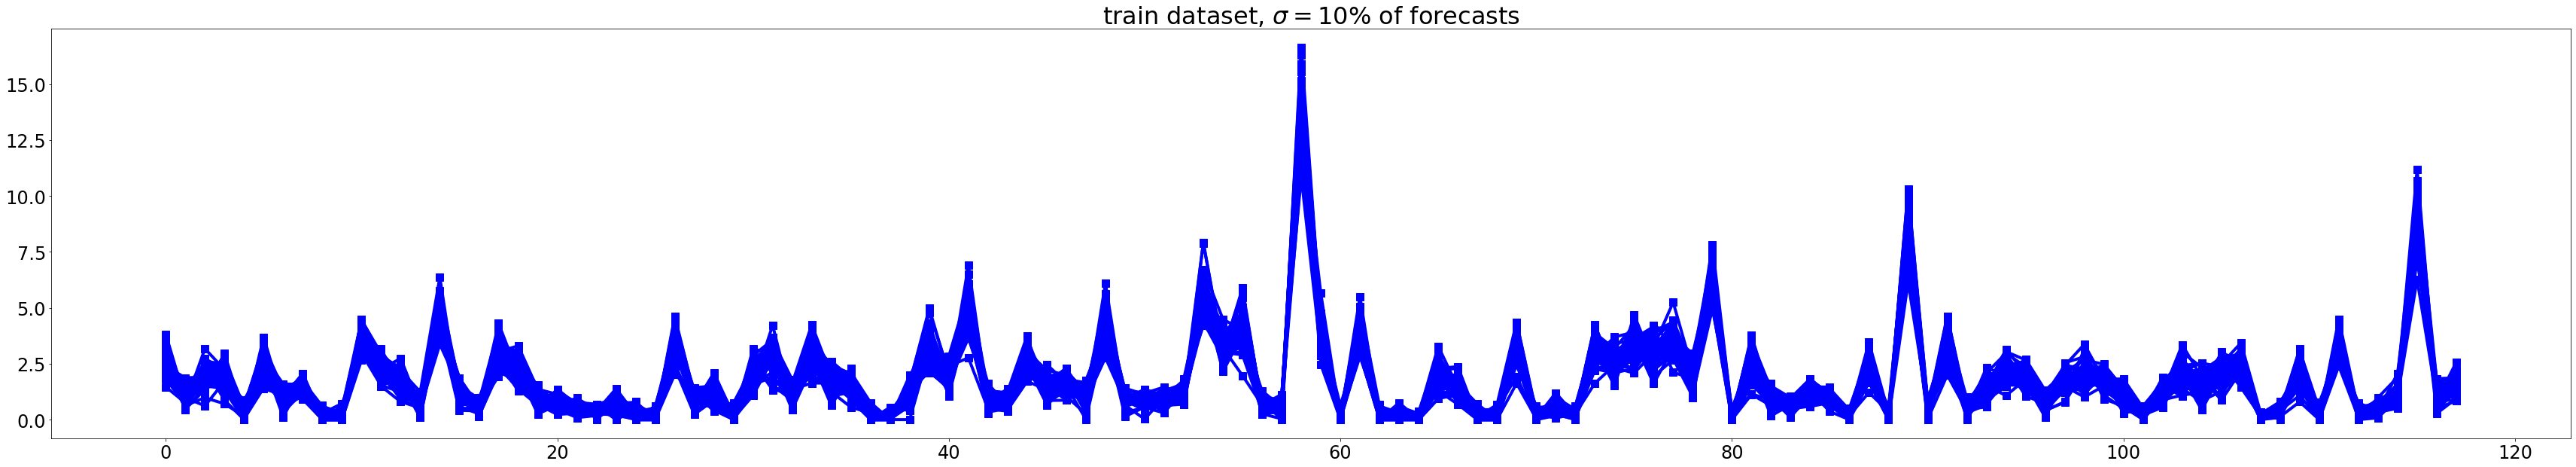

In [ ]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))
N_points = Ntr
for i in range(N_points):
    ax0.plot(Xrange, train_dataset[i,:], 'b-s', markersize=10, linewidth=4)

# ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
# ax0.legend(fontsize=24)
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'train dataset, $\sigma=$'+str(int(input_std*100))+'% of forecasts', fontsize=32, color='k' )
plt.show()

## Construct dataset for pretrain


*   X_train, X_test for action net training
*   X_train2, X_test2 for reward net training


### Format:

*   X_train, X_test: [forecasts, x_true]
*   X_train2, X_test2:[forecasts-x_true, theta_true, y_true, Q_true]


In [ ]:
N_ap = 20
N_gap = 20
N_cp = 50
N_eval = 50

In [ ]:
x_true, _, _ = solver_outer_loop(pretrain_dataset, num_sce=N_cp, solver_name='saa')
X_tr = np.concatenate([pretrain_dataset, x_true], axis=-1)/np.max(pretrain_dataset)
X_train = X_tr[:int(Ntr2*0.9),:]
X_test = X_tr[int(Ntr2*0.9):,:]
# np.save(data_path+'X_train.npy', X_train)
# np.save(data_path+'X_test.npy', X_test)

In [ ]:
Q_omega, y_omega, theta_omega, net_d_omega = solve_stochastic_dcopf(pretrain_dataset, x_true)
X_tr2 = np.concatenate([net_d_omega, theta_omega, y_omega, Q_omega], axis=-1)
X_train2 = X_tr2[:int(Ntr2*0.9),:]
X_test2 = X_tr2[int(Ntr2*0.9):,:]
# np.save(data_path+'X_train2.npy', X_train2)
# np.save(data_path+'X_test2.npy', X_test2)

# visualize.py

In [ ]:
realizations = net_d_omega + x_true
z_actual = x_true+y_omega
total_cost = x_true@da_cost_Coeff + Q_omega

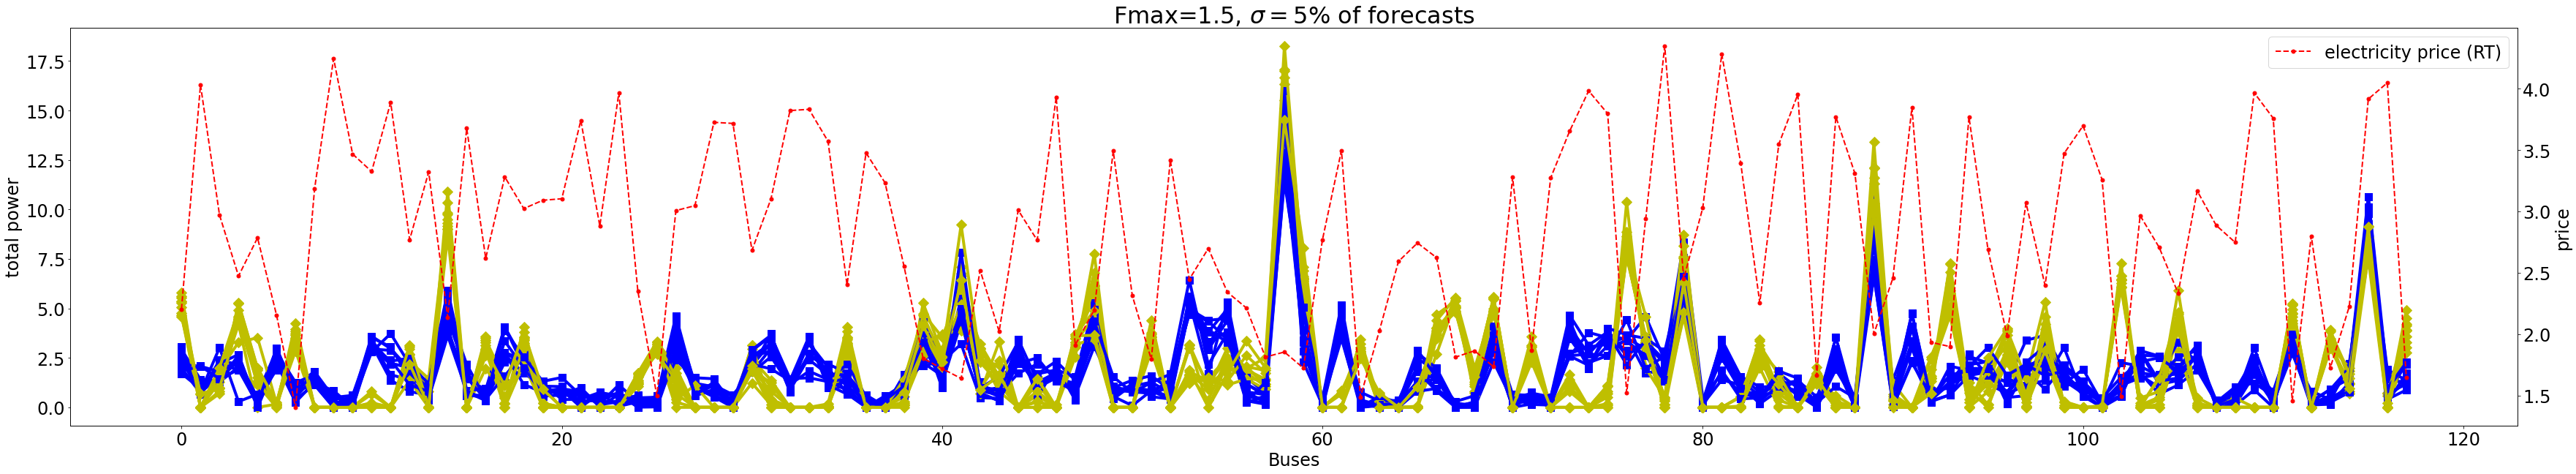

In [ ]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))
N_points = Ntr2
for i in range(N_points):
    ax0.plot(Xrange, realizations[i,:], 'b-s', markersize=10, linewidth=4)
    ax0.plot(Xrange, z_actual[i,:], 'y-D', markersize=10, linewidth=4)

# ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
# ax0.legend(fontsize=24)
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
ax0.set_xlabel('Buses', fontsize=24 )
ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
              fontsize=32, color='k')

ax1 = ax0.twinx()
ax1.plot(range(N), linear_cost_coeff, 'r--o', markersize=5, linewidth=2, label='electricity price (RT)')
ax1.tick_params(axis='y', labelsize=24 )
ax1.set_ylabel('price', fontsize=24, rotation=90 )
ax1.legend(fontsize=24)


plt.show()

## NOTE
z is sparse, because there are no limits on y. if you set line flow limits to be large, then power transfer is allowed and generators with low cost will generate most of the power. As you tighten the line flow limits, you'll restrict most power generations to local instead of network-wide.

# benchmarks.py

## Benchmark1: use cvxpy to solve saa version of the true problem

In [ ]:
test_dataset.shape

(100, 118)

In [ ]:
N_cp = 50
x_cp, _, cp_times = solver_outer_loop(test_dataset, num_sce=N_cp, solver_name='saa')
np.save(data_path+'Nscen50_x_cp.npy', x_cp)
np.save(data_path+'Nscen50_cp_times.npy', cp_times)

In [ ]:
cp_times

array([0.06793523, 0.06228377, 0.06927555, 0.07089975, 0.06260719,
       0.06797525, 0.06897578, 0.06049656, 0.06610758, 0.06219317,
       0.06393222, 0.06392817, 0.06413388, 0.07392517, 0.06437325,
       0.06438355, 0.0658497 , 0.0678124 , 0.07750574, 0.06491396,
       0.06219717, 0.06750228, 0.06416814, 0.07588603, 0.07587257,
       0.06733872, 0.08468872, 0.06284496, 0.06213775, 0.06780132,
       0.06156557, 0.06464281, 0.06718575, 0.06297064, 0.06424896,
       0.0581618 , 0.06416392, 0.0689104 , 0.06629864, 0.0662335 ,
       0.06698481, 0.06369372, 0.06209451, 0.06650891, 0.06916322,
       0.06558625, 0.06249437, 0.06796357, 0.06176517, 0.06571693,
       0.06575445, 0.06183855, 0.06205469, 0.06925917, 0.06345958,
       0.06733692, 0.06187407, 0.06258973, 0.06247129, 0.06734183,
       0.06732764, 0.06797062, 0.0655952 , 0.06947107, 0.06084941,
       0.06802438, 0.07133267, 0.06092329, 0.06193307, 0.06194656,
       0.06467666, 0.08020492, 0.06683888, 0.06586064, 0.06529

In [ ]:
N_cp = 100
x_cp, _, cp_times = solver_outer_loop(test_dataset, num_sce=N_cp, solver_name='saa')
np.save(data_path+'Nscen100_x_cp.npy', x_cp)
np.save(data_path+'Nscen100_cp_times.npy', cp_times)

In [ ]:
saved_path = root_path+'118bus/predictions_cnn/'
x_nu = np.load(saved_path+'x_nu.npy')

In [ ]:
# # Evaluate using evaluate_outer_loop(forecasts, x_pred)
N_eval = 500
total_cost_cp, Q_cp, y_cp = evaluate_outer_loop(test_dataset[:10,:], x_cp, num_sce=N_eval)

np.save(data_path+'Neval500_total_cost_cp.npy', total_cost_cp)
np.save(data_path+'Neval500_Q_cp.npy', Q_cp)
np.save(data_path+'Neval500_y_cp.npy', y_cp)

In [ ]:
# # Evaluate using evaluate_outer_loop(forecasts, x_pred)
N_eval = 500
total_cost_nu, Q_nu, y_nu = evaluate_outer_loop(test_dataset[:10,:], x_nu, num_sce=N_eval)

np.save(data_path+'Neval500_total_cost_nu.npy', total_cost_nu)
np.save(data_path+'Neval500_Q_nu.npy', Q_nu)
np.save(data_path+'Neval500_y_nu.npy', y_nu)

In [ ]:
cp_times

array([0.87146643, 0.83007551, 0.67924057, 0.70711197, 0.69928665,
       0.77553955, 0.64305442, 0.69435303, 0.81014417, 0.65608859])

In [ ]:
total_cost_cp

array([[356.708548  ],
       [320.10339581],
       [334.64250606],
       [347.14043964],
       [326.04094708],
       [345.22770898],
       [326.89719921],
       [344.72624963],
       [323.94851263],
       [346.67542012]])

In [ ]:
cp_times

array([0.06669475, 0.0659405 , 0.07002484, 0.06692321, 0.05886066,
       0.06170225, 0.06543021, 0.06463217, 0.06388998, 0.06290514])

In [ ]:
total_cost_cp

array([[356.82629454],
       [320.14532064],
       [334.7750282 ],
       [346.92888998],
       [325.84775312],
       [345.46889218],
       [327.44947956],
       [344.27445046],
       [324.01735448],
       [346.08910748]])

In [ ]:

total_cost_nu = np.load(saved_path+'total_cost_nu.npy')
Q_nu = np.load(saved_path+'Q_nu.npy')
y_nu = np.load(saved_path+'y_nu.npy')

In [ ]:
total_cost_nu[:10].flatten() - total_cost_cp.flatten()

array([[358.80133749],
       [321.8368384 ],
       [337.88824008],
       [349.74001063],
       [328.50388975],
       [348.5824521 ],
       [328.75436047],
       [347.85612704],
       [326.28047766],
       [348.44317469]])

## Benchmark2: apply affine policy to $\theta$

In [ ]:
x_ap, _, ap_times = solver_outer_loop(test_dataset, num_sce=N_ap, solver_name='ap')

# np.save(data_path+'x_ap.npy', x_ap)
# np.save(data_path+'ap_times.npy', ap_times)

In [ ]:
# # Evaluate using evaluate_outer_loop(forecasts, x_pred)
total_cost_ap, Q_ap, y_ap = evaluate_outer_loop(test_dataset, x_ap, num_sce=N_eval)

# np.save(data_path+'total_cost_ap.npy', total_cost_ap)
# np.save(data_path+'Q_ap.npy', Q_ap)
# np.save(data_path+'y_ap.npy', y_ap)

## Benchmark3: apply affine policy to generation, i.e., $y_i=\alpha_i \sum_{\tilde{d}} + s_i$ and use $y$ to eliminate $\theta$

In [ ]:
x_gap, _, gap_times = solver_outer_loop(test_dataset, num_sce=1, solver_name='gap', use_elimination=True)

# np.save(data_path+'x_gap.npy', x_gap)
# np.save(data_path+'gap_times.npy', gap_times)

/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1338: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


In [ ]:
# Evaluate using evaluate_outer_loop(forecasts, x_pred)
total_cost_gap, Q_gap, y_gap = evaluate_outer_loop(test_dataset, x_gap, num_sce=N_eval)

# np.save(data_path+'total_cost_gap.npy', total_cost_gap)
# np.save(data_path+'Q_gap.npy', Q_ap)
# np.save(data_path+'y_gap.npy', y_ap)

# plotting

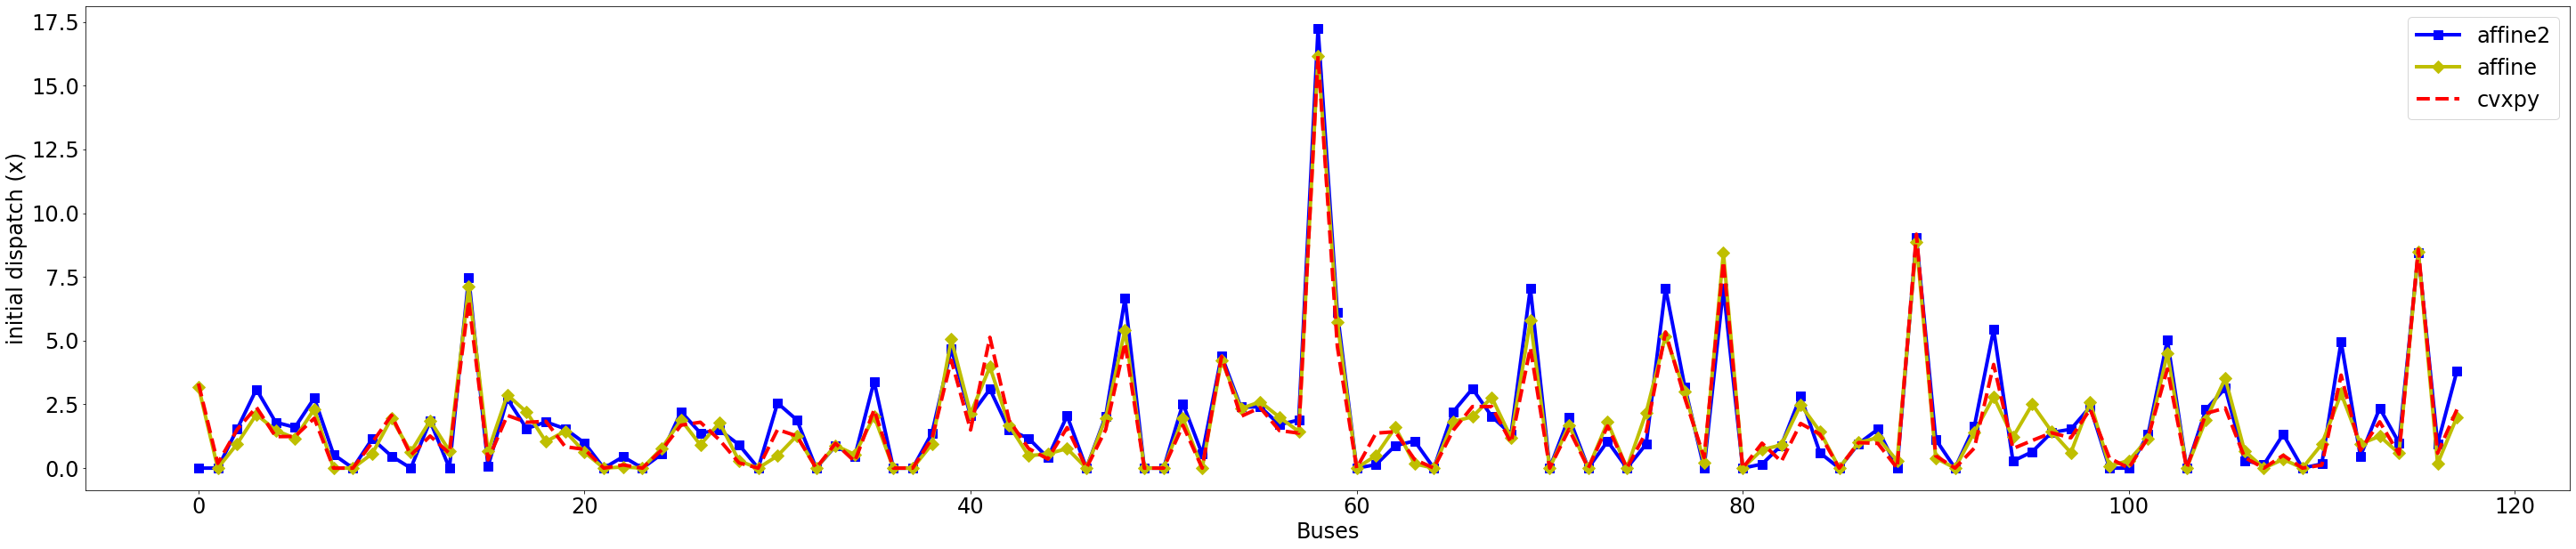

In [ ]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))
N_points = Ntst
for i in range(N_points):
    ax0.plot(Xrange, x_ap[i,:], 'y-D', markersize=10, linewidth=4)
    ax0.plot(Xrange, x_gap[i,:], 'g--', markersize=10, linewidth=4)
    ax0.plot(Xrange, x_cp[i,:], 'r-*', markersize=10, linewidth=4)

# ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
# ax0.legend(fontsize=24)
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
              fontsize=32, color='k')

ax1 = ax0.twinx()
ax1.plot(range(N), linear_cost_coeff, 'k--', markersize=5, linewidth=2, label='electricity price (RT)')
ax1.tick_params(axis='y', labelsize=24 )
ax1.set_ylabel('price', fontsize=24, rotation=90 )
ax1.legend(fontsize=24)


plt.show()

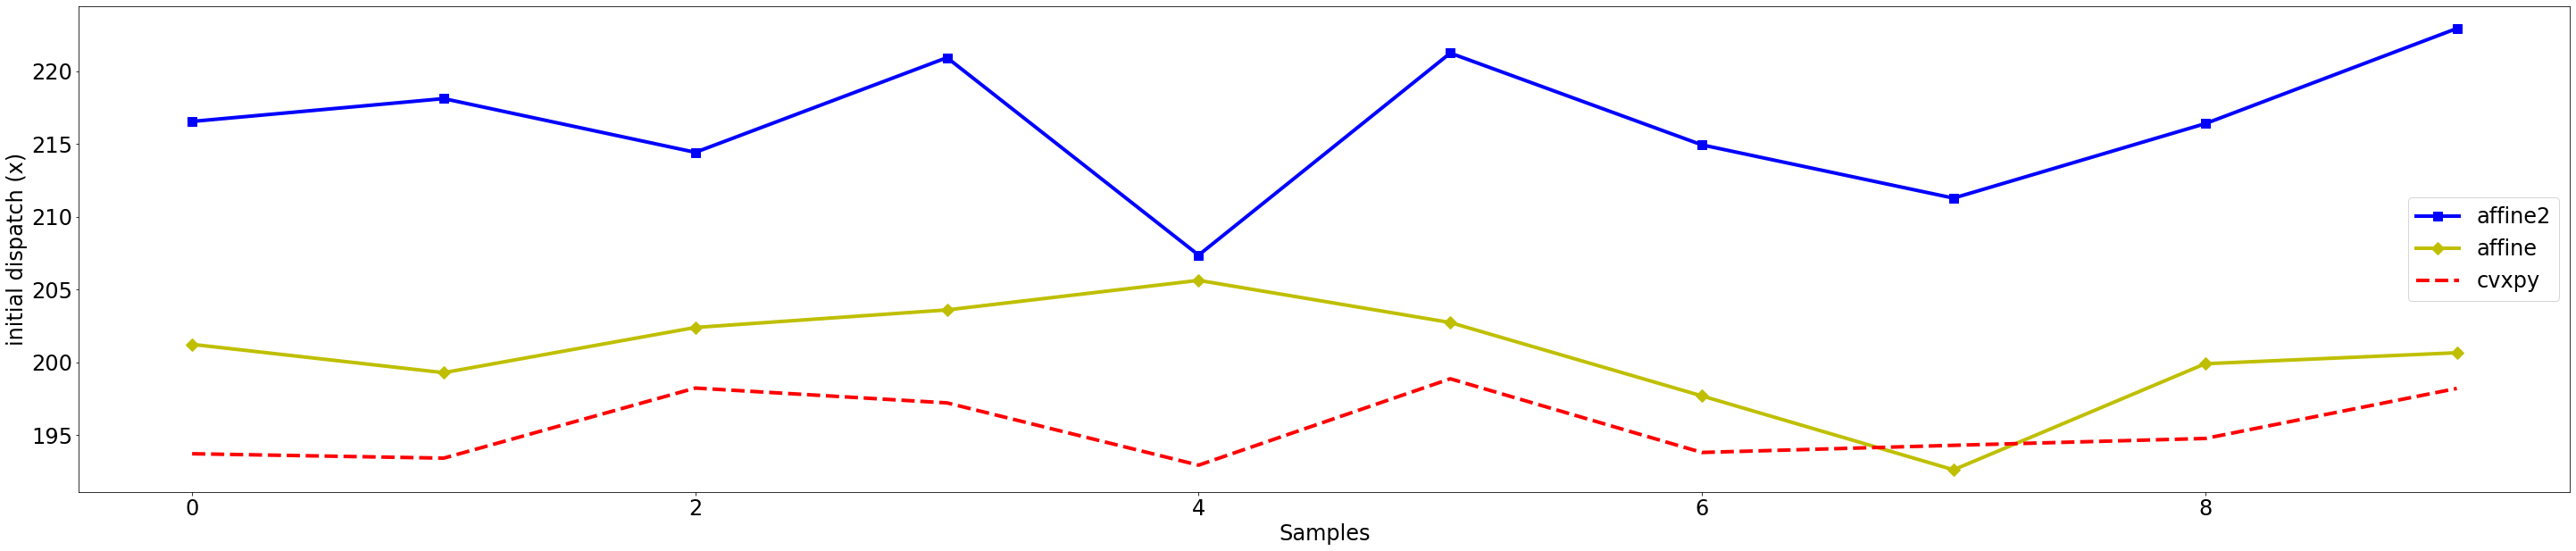

In [ ]:
fig = plt.figure(figsize=(10,10))
Xrange = np.array(range(Ntst))
# N_points = Ntst
plt.plot(Xrange, np.sum(x_ap, axis=-1), 'y-D', markersize=10, linewidth=4, label='ap')
plt.plot(Xrange, np.sum(x_gap, axis=-1), 'g--', markersize=10, linewidth=4, label='gap')
plt.plot(Xrange, np.sum(x_cp, axis=-1), 'r-*', markersize=10, linewidth=4, label='cvxpy')
plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('initial dispatch (x)', fontsize=24)

plt.show()

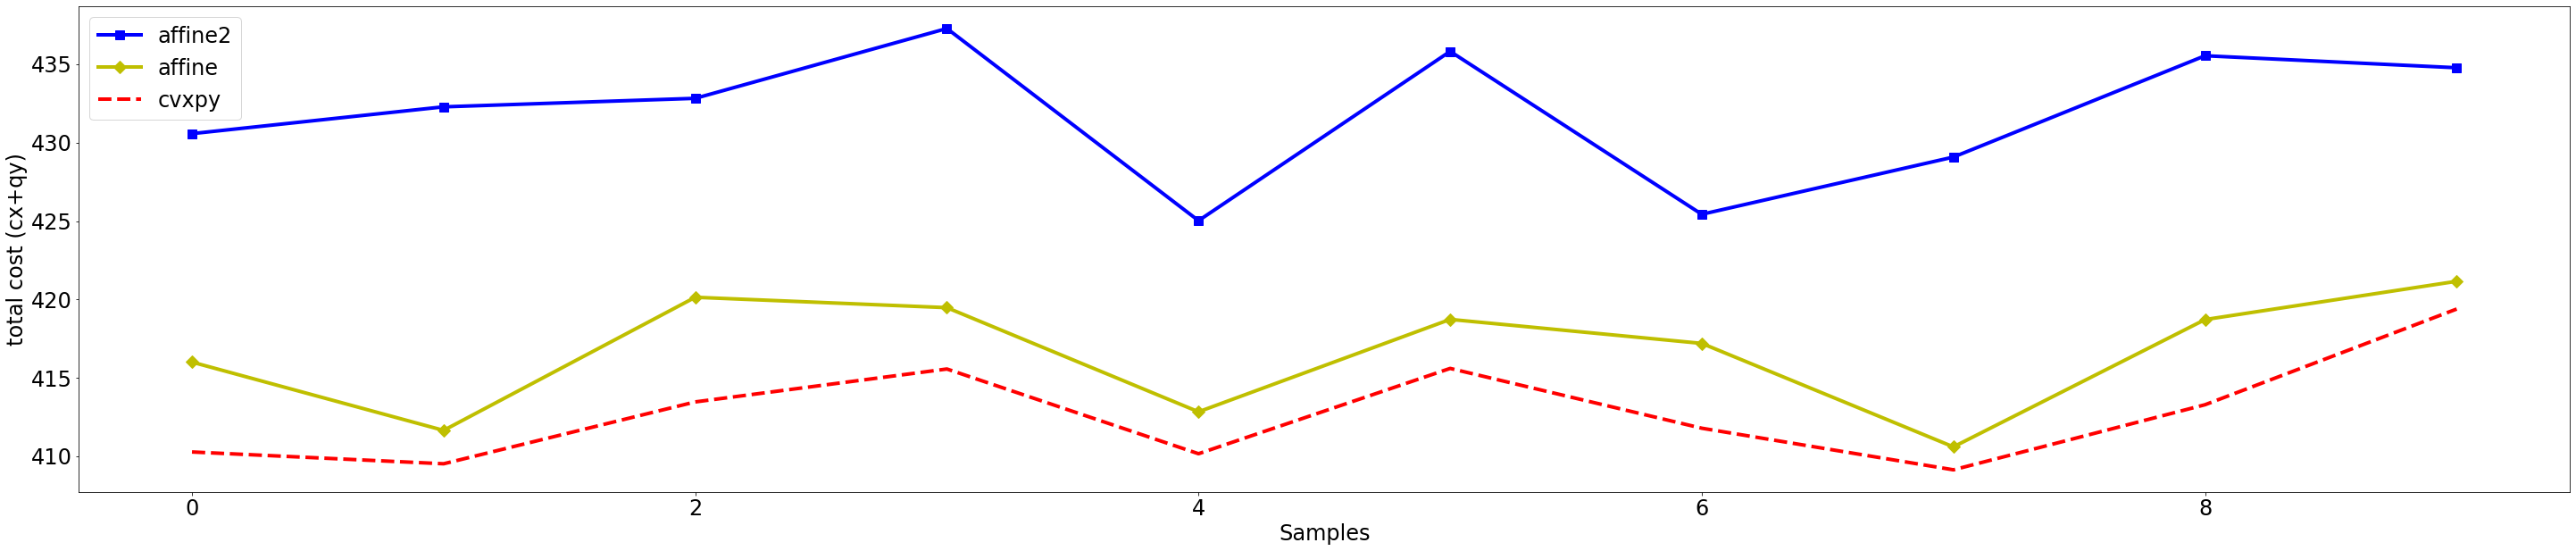

In [ ]:
fig = plt.figure(figsize=(10,10))
Xrange = np.array(range(Ntst))
plt.plot(Xrange, total_cost_ap.flatten(), 'y-D', markersize=10, linewidth=4, label='ap')
plt.plot(Xrange, total_cost_gap.flatten(), 'g--', markersize=10, linewidth=4, label='gap')
plt.plot(Xrange, total_cost_cp.flatten(), 'r-*', markersize=10, linewidth=4, label='cvxpy')

plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('total cost (cx+qy)', fontsize=24)

plt.show()